In [1]:
!sudo nvidia-smi

Mon Nov 17 23:21:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 4000                Off |   00000000:18:00.0 Off |                  N/A |
| 30%   42C    P8              9W /  125W |    3963MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

# List GPUs available
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

# Check if GPUs are available
if gpus:
    print("GPU is available.")
else:
    print("GPU is not available.")

# Set memory growth for each GPU
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


2025-11-17 23:21:10.086182: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-17 23:21:10.140301: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-17 23:21:11.405825: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow version: 2.20.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
GPU is available.


In [3]:
# !pip install matplotlib
# !pip install scikit-learn

In [4]:
# !pip install patchify

In [5]:
# !pip install Pillow

In [6]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [7]:
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape=(128,128,3),
    num_classes=1,
    use_batch_norm=True,
    dropout=0.5,
)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


I0000 00:00:1763421674.294523  286177 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2677 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:18:00.0, compute capability: 7.5
I0000 00:00:1763421674.296220  286177 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6282 MB memory:  -> device: 1, name: Quadro RTX 4000, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [8]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [9]:
scaler = MinMaxScaler()

In [10]:
# root_directory = r".\inputUsers\Januka\Downloads\Compressed\Semantic segmentation dataset"
root_directory = "./data_set/"
patch_size = 256

In [11]:
image_dataset = []

for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = sorted([f for f in os.listdir(path) if f.endswith('.jpg')])  # SORTED
        for image_name in images:
            image = cv2.imread(os.path.join(path, image_name), 1)  # Read as BGR
            SIZE_X = (image.shape[1]//patch_size)*patch_size
            SIZE_Y = (image.shape[0]//patch_size)*patch_size
            image = Image.fromarray(image)
            image = image.crop((0, 0, SIZE_X, SIZE_Y))
            image = np.array(image)

            print("Now patchifying image:", os.path.join(path, image_name))
            patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

            for ii in range(patches_img.shape[0]):
                for jj in range(patches_img.shape[1]):
                    single_patch_img = patches_img[ii, jj, :, :]
                    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                    single_patch_img = single_patch_img[0]  # Drop extra dimension
                    image_dataset.append(single_patch_img)


Now patchifying image: ./data_set/images/post-harvest_01.jpg
Now patchifying image: ./data_set/images/post-harvest_01_2.jpg
Now patchifying image: ./data_set/images/post-harvest_01_3.jpg
Now patchifying image: ./data_set/images/post-harvest_02.jpg
Now patchifying image: ./data_set/images/post-harvest_02_2.jpg
Now patchifying image: ./data_set/images/post-harvest_03.jpg
Now patchifying image: ./data_set/images/post-harvest_03_2.jpg
Now patchifying image: ./data_set/images/post-harvest_03_3.jpg


In [12]:
mask_dataset = []

for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = sorted([f for f in os.listdir(path) if f.endswith('.png')])  # SORTED
        for mask_name in masks:
            mask = cv2.imread(os.path.join(path, mask_name), 1)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            SIZE_X = (mask.shape[1]//patch_size)*patch_size
            SIZE_Y = (mask.shape[0]//patch_size)*patch_size
            mask = Image.fromarray(mask)
            mask = mask.crop((0, 0, SIZE_X, SIZE_Y))
            mask = np.array(mask)

            print("Now patchifying mask:", os.path.join(path, mask_name))
            patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

            for ii in range(patches_mask.shape[0]):
                for jj in range(patches_mask.shape[1]):
                    single_patch_mask = patches_mask[ii, jj, :, :]
                    single_patch_mask = single_patch_mask[0]  # Drop extra dimension
                    mask_dataset.append(single_patch_mask)


Now patchifying mask: ./data_set/masks/post-harvest_01.png
Now patchifying mask: ./data_set/masks/post-harvest_01_2.png
Now patchifying mask: ./data_set/masks/post-harvest_01_3.png
Now patchifying mask: ./data_set/masks/post-harvest_02.png
Now patchifying mask: ./data_set/masks/post-harvest_02_2.png
Now patchifying mask: ./data_set/masks/post-harvest_03.png
Now patchifying mask: ./data_set/masks/post-harvest_03_2.png
Now patchifying mask: ./data_set/masks/post-harvest_03_3.png


In [13]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [14]:
# #For RGB mask, activate this block and deactivat the following block
# #Sanity check, view few images
# import random
# import numpy as np
# image_number = random.randint(0, len(image_dataset))
# plt.figure(figsize=(12, 6))
# plt.subplot(121)
# plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
# plt.subplot(122)
# plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
# plt.show()

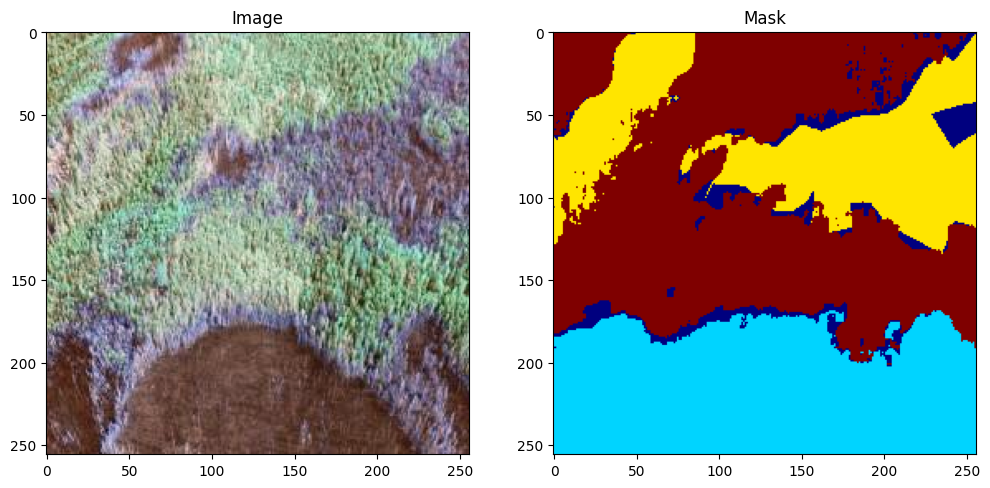

In [16]:
#For single channel mask, activate this block and deactivat the previous block
# Sanity check, view few images
import random
import matplotlib.pyplot as plt

image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))

# Show the image
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.title("Image")

# Show the mask
plt.subplot(122)
plt.imshow(mask_dataset[image_number][:,:,0], cmap='jet', vmin=0, vmax=3)  # single-channel mask
plt.title("Mask")
# plt.colorbar()
plt.show()


In [ ]:
"""
RGB to HEX: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives
the first hexadecimal digit (between 0 and F, where the letters A to F represent
the numbers 10 to 15). The remainder gives the second hexadecimal digit.
0-9 --> 0-9
10-15 --> A-F

Example: RGB --> R=201, G=, B=

R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)

Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152

"""

In [ ]:
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60.
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

In [ ]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels

    return label_seg

In [ ]:
# # If masks are RGB, activate this block and deactivate the following block
# labels = []
# for i in range(mask_dataset.shape[0]):
#     label = rgb_to_2D_label(mask_dataset[i])
#     labels.append(label)

# labels = np.array(labels)
# labels = np.expand_dims(labels, axis=3)


# print("Unique labels in label dataset are: ", np.unique(labels))

# #Another Sanity check, view few images
# import random
# import numpy as np
# image_number = random.randint(0, len(image_dataset))
# plt.figure(figsize=(12, 6))
# plt.subplot(121)
# plt.imshow(image_dataset[image_number])
# plt.subplot(122)
# plt.imshow(labels[image_number][:,:,0])
# plt.show()

In [ ]:
# If masks are already single-channe, activate this block and deactivat the previous block
 
# Directly use the mask dataset and expand dims for channels
labels = mask_dataset[..., np.newaxis]  # shape: (num_images, H, W, 1)

print("Unique labels in label dataset are: ", np.unique(labels))


#Another Sanity check, view few images
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()


In [ ]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


In [ ]:
#Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')),
#                               np.ravel(labels,order='C'))
# print(weights)


In [ ]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #



In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [ ]:
#original code
# def jacard_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [ ]:
def jacard_coef(y_true, y_pred, smooth=1e-7):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    
    return (intersection + smooth) / (union + smooth)

In [ ]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
metrics=['accuracy', jacard_coef]

In [ ]:
def get_model():
    return multi_unet_model(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
model.summary()

In [ ]:
print(X_train.shape, y_train.shape)


In [ ]:
X_train = X_train.astype('float16')
y_train = y_train.astype('float16')
X_test = X_test.astype('float16')
y_test = y_test.astype('float16')

In [ ]:
def data_generator(X, y, batch_size=8):
    total_samples = X.shape[0]
    indices = np.arange(total_samples)
    while True:
        np.random.shuffle(indices)
        for start in range(0, total_samples, batch_size):
            end = min(start + batch_size, total_samples)
            batch_indices = indices[start:end]
            yield X[batch_indices], y[batch_indices]

train_gen = data_generator(X_train, y_train, batch_size=4)
test_gen = data_generator(X_test, y_test, batch_size=4)

In [ ]:
history1 = model.fit(train_gen,
                     steps_per_epoch=len(X_train) // 4,  # Adjusted to new batch size
                     verbose=1,
                     epochs=100,
                     validation_data=test_gen,
                     validation_steps=len(X_test) // 4,
                     shuffle=False)

In [ ]:
model.save("./satellite_standard_unet_100epochs_12Nov2025.keras")

In [ ]:
#plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

